# 基於密度之含噪空間階層聚類法(Hierarchical Density-Based Spatial Clustering of Applications with Noise)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
from scipy.spatial.distance import cdist

# MNIST Dataset

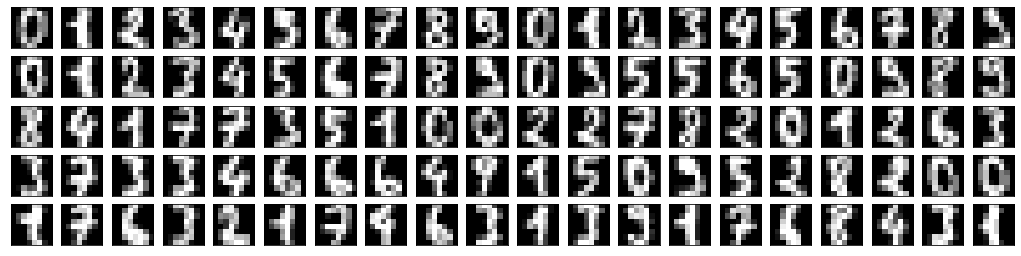

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=(digits.data/16)
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Principal Component Anlysis

In [3]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded

# Mutual Reachability Graph

In [4]:
MinPt=5
dist = cdist(X,X,"sqeuclidean")
core_dist=np.sort(dist,axis=1)[:,MinPt]
core_dist_2d=np.maximum(core_dist[:,None],core_dist[None,:])
dist_2d=np.maximum(dist,dist.T)
MRG=np.maximum(dist,core_dist_2d)
print(MRG)

[[ 0.6953125  13.85546875 11.4453125  ...  9.9140625   5.3671875
   8.640625  ]
 [13.85546875  1.765625    6.76953125 ...  5.81640625  9.21484375
   9.89453125]
 [11.4453125   6.76953125  2.9609375  ...  5.7421875  10.0703125
   7.546875  ]
 ...
 [ 9.9140625   5.81640625  5.7421875  ...  2.25390625  7.6171875
   3.2578125 ]
 [ 5.3671875   9.21484375 10.0703125  ...  7.6171875   2.26953125
   6.0703125 ]
 [ 8.640625    9.89453125  7.546875   ...  3.2578125   6.0703125
   3.00390625]]


# Minimum Spanning Tree

In [5]:
from scipy.sparse.csgraph import minimum_spanning_tree
MST=minimum_spanning_tree(MRG).toarray()
print(MST)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Plot MST

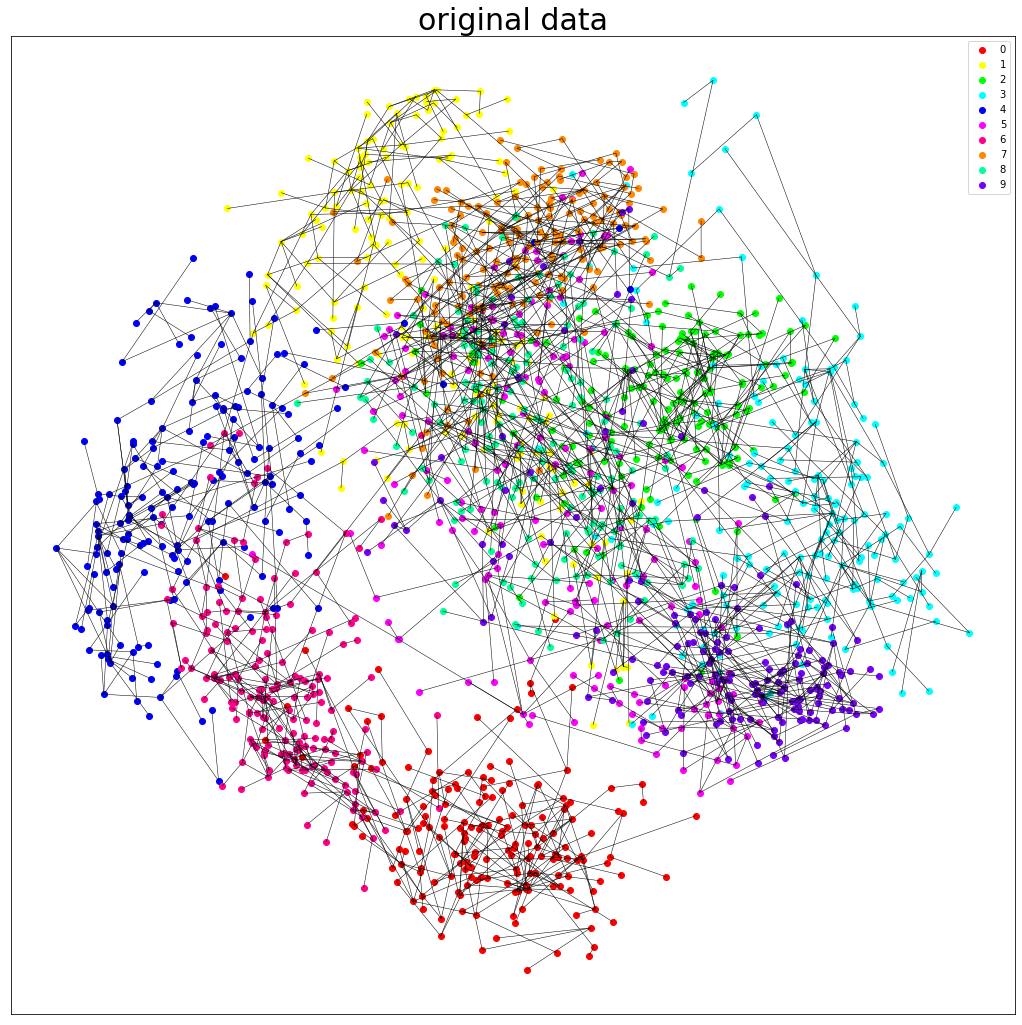

In [6]:
N=X.shape[0]
X_embedded=PCA(X,2,N)
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
for i in range(N):
    for j in range(N):
        if(MST[i,j]==0.):
            continue
        else:
            plt.plot([X_embedded[i,0],X_embedded[j,0]],[X_embedded[i,1],X_embedded[j,1]],
                     c="k",linewidth=0.5)
for i in range(0,10):
    plt.scatter(X_embedded[(y==i),0],X_embedded[(y==i),1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()

# Hierarchical Clustering

In [7]:
def cluster(MST_tmp,start_point,label,dim,CLASS):
    label[start_point]=CLASS
    if(dim==0):
        index=np.array(np.where(MST_tmp[start_point,:]!=0.)).flatten()
        dim=1
    else:
        index=np.array(np.where(MST_tmp[:,start_point]!=0.)).flatten()
        dim=0
    for idx in index:
        if(label[idx]==-1):
            label=cluster(MST_tmp,idx,label,dim,CLASS)
        else:
            continue
    return label
def split_cluster(MST_new,MST_ravel,sort_index,start_index,label,old_label,
                  CLASS,min_cluster_size,max_cluster_size):
    for i in range(start_index,len(sort_index)):
        if(CLASS>cluster_size):
            break
        if(i>3000):
            break
        horiz=int(sort_index[i]/N)
        verti=int(sort_index[i]%N)
        horizontal_num=np.sum(MST_new[horiz,:]!=0.)
        vertical_num=np.sum(MST_new[:,verti]!=0.)
        if(horizontal_num==0 and vertical_num==0):
            continue
        if(vertical_num>1 and horizontal_num>1):
            MST_tmp=MST_new.copy()
            MST_tmp[horiz,verti]=0.
            MST_tmp[verti,horiz]=0.
            CLASS_tmp=CLASS
            
            for k in range(N):
                if(label[k]==-1):
                    label=cluster(MST_tmp,k,label,0,CLASS_tmp)
                    CLASS_tmp+=1
                else:
                    continue
            CLASS1_num=np.sum(label==CLASS)
            CLASS2_num=np.sum(label==(CLASS+1))
            if(CLASS1_num>min_cluster_size and CLASS2_num>min_cluster_size):
                print(CLASS)
                print(horiz,verti,"is the splitting tree node")
                print("left cluster has",CLASS1_num,"points / right cluster has",CLASS2_num,"points")
                print("================================")
                if(CLASS1_num<max_cluster_size and CLASS2_num<max_cluster_size):
                    old_label=label.copy()
                    CLASS+=2
                    break
                elif(CLASS1_num<max_cluster_size and CLASS2_num>max_cluster_size):
                    remove_index=np.array(np.where(label==CLASS)).flatten()
                    label[label==(CLASS+1)]=-1
                    MST_new[remove_index,:]=0.
                    MST_new[:,remove_index]=0.
                    old_label=label.copy()
                    CLASS+=1
                    label,old_label,CLASS=split_cluster(MST_new,MST_ravel,sort_index,i+1,
                                              label,old_label,CLASS,min_cluster_size,max_cluster_size)
                    break
                elif(CLASS1_num>max_cluster_size and CLASS2_num<max_cluster_size):
                    remove_index=np.array(np.where(label==(CLASS+1))).flatten()
                    label[label==(CLASS)]=-1
                    label[label==(CLASS+1)]=CLASS
                    MST_new[remove_index,:]=0.
                    MST_new[:,remove_index]=0.
                    old_label=label.copy()
                    CLASS+=1
                    label,old_label,CLASS=split_cluster(MST_new,MST_ravel,sort_index,i+1,
                                              label,old_label,CLASS,min_cluster_size,max_cluster_size)
                    break
                elif(CLASS1_num>max_cluster_size and CLASS2_num>max_cluster_size):
                    temp_CLASS=12
                    remove_index1=np.array(np.where(label==(CLASS+1))).flatten()
                    remove_index2=np.array(np.where(label==CLASS)).flatten()
                    MST_new1=MST_new.copy()
                    MST_new1[remove_index1,:]=0.
                    MST_new1[:,remove_index1]=0.
                    label[label==CLASS]=-1
                    label[label==(CLASS+1)]=temp_CLASS
                    old_label=label.copy()
                    label,old_label,CLASS=split_cluster(MST_new1,MST_ravel,sort_index,i+1,
                                              label,old_label,CLASS,min_cluster_size,max_cluster_size)
                    MST_new2=MST_new.copy()
                    MST_new2[remove_index2,:]=0.
                    MST_new2[:,remove_index2]=0.
                    label[label==temp_CLASS]=-1                    
                    old_label=label.copy()
                    label,old_label,CLASS=split_cluster(MST_new2,MST_ravel,sort_index,i+1,
                                              label,old_label,CLASS,min_cluster_size,max_cluster_size)
                    break
                label=old_label.copy()
            else:
                label=old_label.copy()
    return label,old_label,CLASS

# HDBSCAN

In [8]:
MST_ravel=MST.ravel()
sort_index=np.argsort(MST_ravel)[::-1]
MST_new=MST+MST.T
label=np.zeros(N,dtype=int)
cluster_size=10
min_cluster_size=120
max_cluster_size=240
old_label=np.ones(N,dtype=int)*-1
label=np.ones(N,dtype=int)*-1
CLASS=0
label,old_label,CLASS=split_cluster(MST_new,MST_ravel,sort_index,0,label,old_label,
                          CLASS,min_cluster_size,max_cluster_size)

0
843 101 is the splitting tree node
left cluster has 177 points / right cluster has 1620 points
1
1405 329 is the splitting tree node
left cluster has 1436 points / right cluster has 184 points
2
205 787 is the splitting tree node
left cluster has 1270 points / right cluster has 166 points
3
227 496 is the splitting tree node
left cluster has 1095 points / right cluster has 175 points
4
1792 1423 is the splitting tree node
left cluster has 581 points / right cluster has 514 points
4
95 667 is the splitting tree node
left cluster has 374 points / right cluster has 207 points
5
1327 242 is the splitting tree node
left cluster has 192 points / right cluster has 182 points
7
446 478 is the splitting tree node
left cluster has 180 points / right cluster has 334 points
8
944 1018 is the splitting tree node
left cluster has 148 points / right cluster has 186 points


# Plot

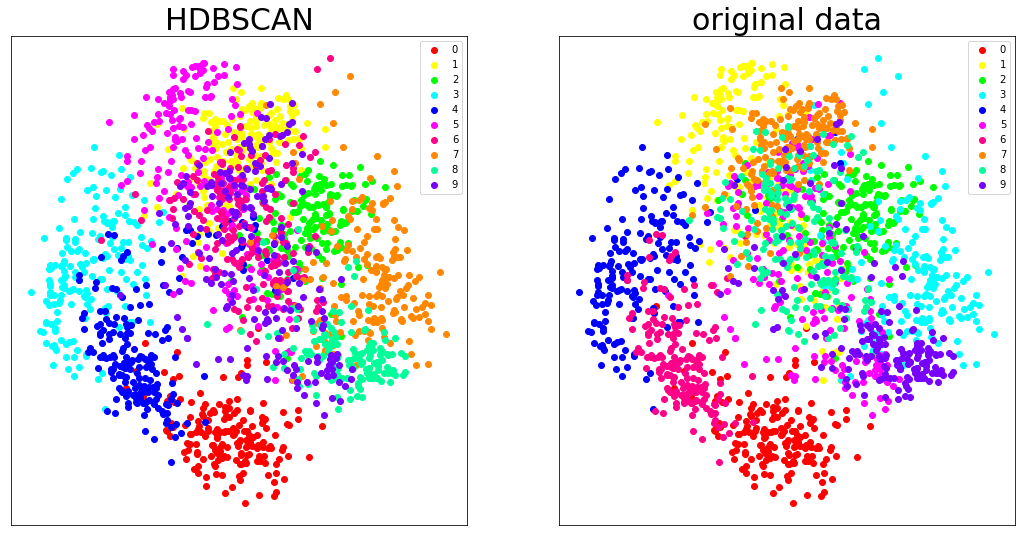

In [9]:
plt.rcParams["figure.figsize"] = (18,9)
fig , ax = plt.subplots()
plt.subplot(1, 2, 1)
for i in range(0,10):
    BOOL=(label==i)
    plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[i],label=i)
plt.title("HDBSCAN",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.subplot(1, 2, 2)
for i in range(0,10):
    plt.scatter(X_embedded[(y==i),0],X_embedded[(y==i),1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()